In [1]:
import sys
import os

exlib_path = "/shared_data0/chaenyk/exlib"
src_path = os.path.join(exlib_path, "src")
sys.path.insert(0, src_path)
import pyarrow as pa
import pyarrow_hotfix
import torch
import yaml
import argparse
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import namedtuple
import matplotlib.pyplot as plt

import exlib
from exlib.datasets.pretrain import setup_model_config, get_dataset, get_dataset, setup_model_config
from exlib.datasets.dataset_preprocess_raw import create_train_dataloader_raw, create_test_dataloader_raw, create_test_dataloader, plot_data_by_wavelength
from exlib.datasets.informer_models import InformerConfig, InformerForSequenceClassification
from tqdm.auto import tqdm
pa.PyExtensionType.set_auto_load(True)
pyarrow_hotfix.uninstall()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from supernova import Timeseries, get_llm_generated_answer, isolate_individual_features, is_claim_relevant, distill_relevant_features, calculate_expert_alignment_score

In [2]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import openai
from openai import OpenAI
import time
from tqdm import tqdm

from diskcache import Cache
cache = Cache("/shared_data0/llm_cachedir")

In [3]:
import openai
from openai import OpenAI

with open("openai_key.txt", "r") as f:
    api_key = f.read().strip()

client = OpenAI(api_key=api_key)

### Dataset

In [4]:
# load dataset
dataset = load_dataset("BrachioLab/supernova-timeseries")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [5]:
test_dataset

Dataset({
    features: ['objid', 'times_wv', 'target', 'label', 'redshift'],
    num_rows: 792
})

### Dataset Samples

In [6]:
config = InformerConfig.from_pretrained("BrachioLab/supernova-classification")
test_dataloader = create_test_dataloader_raw(
    config=config,
    dataset=test_dataset,
    batch_size=25,
    compute_loss=True
)

original dataset size: 792
remove nans dataset size: 792


In [7]:
def find_unique_labels(dataloader):
    all_labels = set()
    for batch in dataloader:
        batch_labels = batch['labels'].unique().tolist()
        all_labels.update(batch_labels)
    return sorted(all_labels)

unique_labels = find_unique_labels(test_dataloader)
print(f"Found {len(unique_labels)} unique labels: {unique_labels}")

Found 14 unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [8]:
def find_label_in_dataloader(dataloader, target_label=11):
    for batch in dataloader:
        indices = (batch['labels'] == target_label).nonzero(as_tuple=True)[0]
        
        if len(indices) > 0:
            label_values_time = batch['past_time_features'][indices, :, :]
            label_values = batch['past_values'][indices, :, :]
            return label_values_time, label_values
    
    return None, None

In [9]:
label_data = {}
for label in unique_labels:
    label_past_time, label_past_values = find_label_in_dataloader(test_dataloader, target_label=label)
    
    if label_past_time is not None and label_past_values is not None:
        label_data[label] = {
            'past_time': label_past_time,
            'past_values': label_past_values
        }
        print(f"Extracted data for label {label}, found {label_past_time.shape[0]} instances")
    else:
        print(f"No instances found for label {label}")

Extracted data for label 0, found 13 instances
Extracted data for label 1, found 7 instances
Extracted data for label 2, found 13 instances
Extracted data for label 3, found 14 instances
Extracted data for label 4, found 7 instances
Extracted data for label 5, found 3 instances
Extracted data for label 6, found 6 instances
Extracted data for label 7, found 11 instances
Extracted data for label 8, found 12 instances
Extracted data for label 9, found 20 instances
Extracted data for label 10, found 1 instances
Extracted data for label 11, found 19 instances
Extracted data for label 12, found 24 instances
Extracted data for label 13, found 18 instances


In [21]:
# SNIa class 11
cls = 11
n = 0
time_data = label_data[cls]['past_time'][n,:,0]
wv_data = label_data[cls]['past_time'][n,:,1]
value_data = label_data[cls]['past_values'][n,:,0]
error_data = label_data[cls]['past_values'][n,:,1]

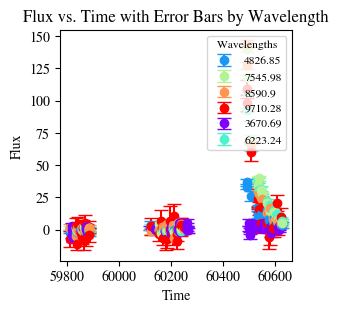

In [22]:
plot_data_by_wavelength(time_data, value_data, error_data, wv_data, 'Flux vs. Time with Error Bars by Wavelength')

In [23]:
### Extract Explanation
example = Timeseries(time=time_data, wv=wv_data, value=value_data)
analysis_result = get_llm_generated_answer(example=example)
print(analysis_result)

Class: Type Ia Supernova (SNIa)

Explanation: The data provided closely matches the characteristics of a Type Ia Supernova (SNIa). This classification is supported by several key features observed in the data. Firstly, the time series data shows a consistent pattern of observations across multiple wavelengths, which is typical for SNIa events that are well-studied and have a predictable light curve. The wavelength data includes a range of values that are commonly used in supernova observations, such as 4826.85, 7545.98, and 9710.28, which are often associated with the spectral features of SNIa. Additionally, the value data shows significant variability, with both positive and negative values, indicating the presence of a strong peak and subsequent decline, a hallmark of SNIa light curves. The presence of high values in the later stages of the time series suggests the characteristic brightness of SNIa, which is used as a standard candle in cosmology. These features collectively point to

In [24]:
### Make it to atomic claims
raw_atomic_claims = isolate_individual_features(analysis_result)

print("Extracted atomic claims:")
for i, claim in enumerate(raw_atomic_claims, 1):
    print(f"{i}. {claim}")

Extracted atomic claims:
1. The data provided closely matches the characteristics of a Type Ia Supernova (SNIa).
2. The classification as SNIa is supported by several key features observed in the data.
3. The time series data shows a consistent pattern of observations across multiple wavelengths.
4. SNIa events are well-studied and have a predictable light curve.
5. The wavelength data includes values such as 4826.85, 7545.98, and 9710.28.
6. These wavelength values are commonly used in supernova observations and are associated with the spectral features of SNIa.
7. The value data shows significant variability with both positive and negative values.
8. The variability indicates the presence of a strong peak and subsequent decline, a hallmark of SNIa light curves.
9. High values in the later stages of the time series suggest the characteristic brightness of SNIa.
10. SNIa brightness is used as a standard candle in cosmology.
11. The features collectively point towards the classification

In [25]:
### Relevant claims
example = Timeseries(time=time_data, wv=wv_data, value=value_data)
answer = 'Type Ia supernovae (SNIa)'
claim_relevances = [is_claim_relevant(example, answer, raw_atomic_claim, 0.8) \
    for raw_atomic_claim in raw_atomic_claims]
claim_relevances

[False, False, False, False, False, False, False, True, True, False, False]

In [27]:
### Distilled relevant claims
example = Timeseries(time=time_data, wv=wv_data, value=value_data)
answer = 'Type Ia supernovae (SNIa)'

distilled_claims = distill_relevant_features(example, answer, raw_atomic_claims, 0.8)

print("Distilled relevant claims:")
for i, claim in enumerate(distilled_claims, 1):
    print(f"{i}. {claim}")

Distilled relevant claims:
1. The variability indicates the presence of a strong peak and subsequent decline, a hallmark of SNIa light curves.
2. High values in the later stages of the time series suggest the characteristic brightness of SNIa.


In [29]:
### Compute alignment scores
scores = calculate_expert_alignment_score(distilled_claims)
scores

{'alignment_scores': [{'claim': 'The variability indicates the presence of a strong peak and subsequent decline, a hallmark of SNIa light curves.',
   'score': 5},
  {'claim': 'High values in the later stages of the time series suggest the characteristic brightness of SNIa.',
   'score': 4}],
 'total_score': 4.5}